# Time Series Analysis of the Stock Market 
## Prediction of S&P 500 Index (Regression problem)

<ul>
    <li><a href="#Load-Data">Load Data</a></li>
    <li><a href="#Data-Preprocessing">Data Preprocessing</a></li>
    <li><a href="#Ensemble-methods-(Bootstrap-averaging)">Ensemble methods (Bootstrap-averaging)</a></li>
        <ul>
            <li><a href="#Bagging-KNN">Bagging KNN</a></li>
            <li><a href="#Random-Forest">Random-Forest</a></li>
        </ul>
    <li><a href="#Single-KNN">Single KNN</a></li>
    <li><a href="#Conclusion">Conclusion</a></li>
</ul>

## Load Data

In [2]:
import numpy as np
from pandas.io import data
import datetime

In [3]:
# download S&P 500 data from 1995-01-01 up to nowadays
start = datetime.datetime(1995, 1, 1)
end = datetime.datetime(2016, 11, 30)

df = data.DataReader("^GSPC", 'yahoo', start, end).asfreq('W-FRI', method='pad')
df.shape

(1143, 6)

In [4]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

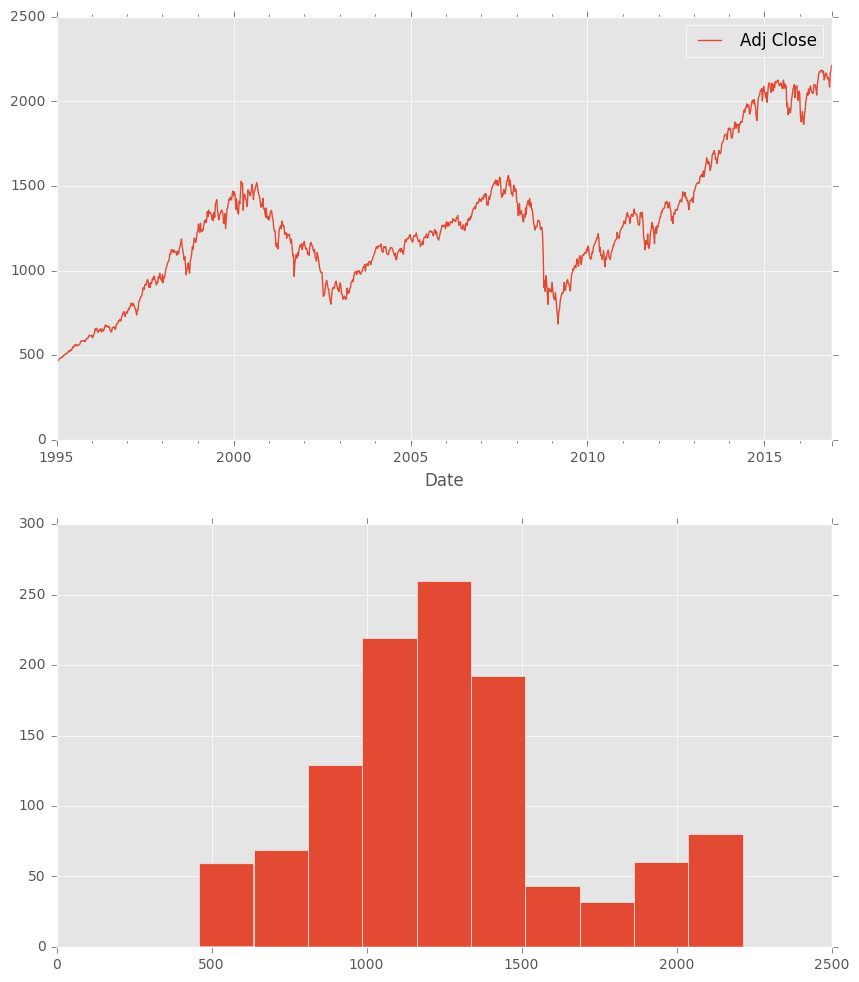

In [5]:
# let's take a brief look at the data
fig, axes = plt.subplots(2,1, figsize=(10,12))
df['Adj Close'].plot(legend=True, ax=axes[0])
df['Adj Close'].hist(ax=axes[1])
plt.show()

## Data Preprocessing
To perform predictive analysis we need to do some preprocessing steps. In case of the financial data the widely used approach is calculating log returns: 
ln(Xt/Xt-1)

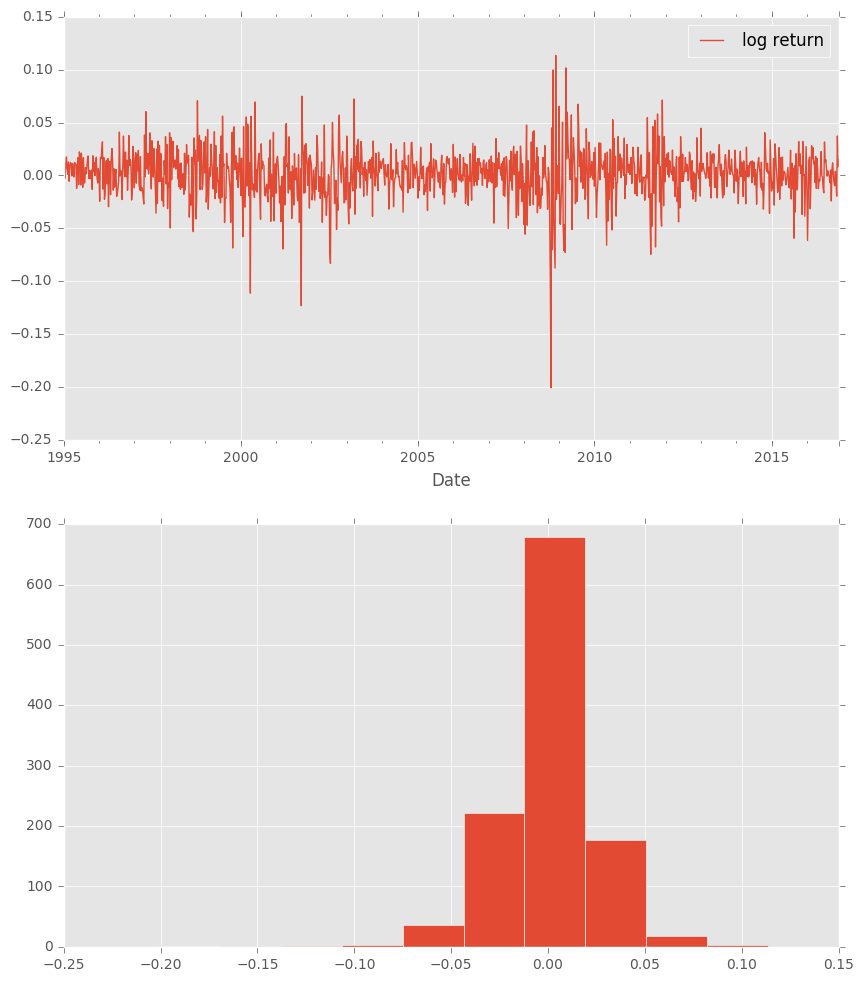

In [6]:
df['return'] = np.log(df['Adj Close'] / df['Adj Close'].shift(1))

fig, axes = plt.subplots(2,1,figsize=(10,12))
df['return'].plot(label='log return', legend=True, ax=axes[0])
df['return'].hist(ax=axes[1])
plt.show()

In [7]:
df[['Adj Close', 'return']].dropna().describe()

,Adj Close,return
count,1142.000000,1142.000000
mean,1264.596997,0.001374
std,394.925785,0.024154
min,464.779999,-0.200838
25%,1027.875030,-0.011296
50%,1233.550049,0.002681
75%,1430.412506,0.014416
max,2213.350098,0.113559


To get predictors for our regression issue, we will use original observations in moment t+1. In other words our training dataset will be look like this:
<pre>
    | Xt   |  Xt+1  |
    | Xt+1 |  Xt+2  |
    | Xt+2 |  Xt+3  |
</pre>

In [8]:
def create_dataset(dataset, look_back=1):
    """
    Prepare time series data for predictive analysis
    """
    x, y = [], []
    for i in range(len(dataset)-look_back):
        x.append(dataset[i:(i+look_back)])
        y.append(dataset[i + look_back])
    return np.array(x), np.array(y)


# split data to train/test datasets
look_back = 8
train_size = int(df['return'].dropna().shape[0] * 0.95) # we will obtain predictions for only few steps ahead
dataset = df['return'].dropna().values
train, test = dataset[0:train_size], dataset[train_size:]

X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1076, 8), (1076,), (50, 8), (50,))

## Ensemble methods (Bootstrap averaging)

### Bagging KNN

In [9]:
from sklearn import ensemble, grid_search, neighbors
seed = 7
rng = np.random.RandomState(seed)

#### Create model

In [11]:
bag_knn = ensemble.BaggingRegressor(
    neighbors.KNeighborsRegressor(n_neighbors=10, weights='distance', metric='manhattan'),
    oob_score=True,
    max_samples=0.7, 
    max_features=0.5,
    random_state=rng
).fit(X_train, y_train)

In [12]:
def inverse_log_return(log_preds, original):
    """
    Inverse transformation of log returns
    We take last observed original value and prepend it in preds array, 
    then we multiply exp(preds[i+1]) by preds[i] 
    inputs:
        log returns predicted by model
        original value
    return:
        inverse transformed values
    """
    inverted = np.full_like(log_preds, np.nan)
    inverted = np.insert(inverted, 0, original.get(0))
    
    i = 0
    while i < log_preds.shape[0]:
        inverted[i+1] = np.exp(log_preds[i]) * inverted[i]
        i += 1
    return inverted

In [13]:
# save observed values to compare its with predictions
y_train_original = df['Adj Close'].ix[look_back:train_size]

# 1+train_size because first value in returns is absent
y_test_original = df['Adj Close'].ix[1+train_size+look_back:]

y_train_original.shape, y_test_original.shape

((1076,), (50,))

#### Generate predictions

In [14]:
preds_train = inverse_log_return(bag_knn.predict(X_train), y_train_original)
preds_test = inverse_log_return(bag_knn.predict(X_test), df['Adj Close'].ix[train_size+look_back:])

preds_train.shape, preds_test.shape

((1077,), (51,))

#### Evaluate model

In [15]:
from sklearn.metrics import mean_squared_error

# preds[1:] - it was inserted last value of train sample
train_mse = mean_squared_error(y_train_original.values, preds_train[1:])
test_mse = mean_squared_error(y_test_original.values, preds_test[1:])

print 'Model Score: {0:.2f} MSE ({1:.2f} RMSE)'.format(train_mse, np.sqrt(train_mse))
print 'Model Score: {0:.2f} MSE ({1:.2f} RMSE)'.format(test_mse, np.sqrt(test_mse))

Model Score: 89323.73 MSE (298.87 RMSE)
Model Score: 4073.09 MSE (63.82 RMSE)


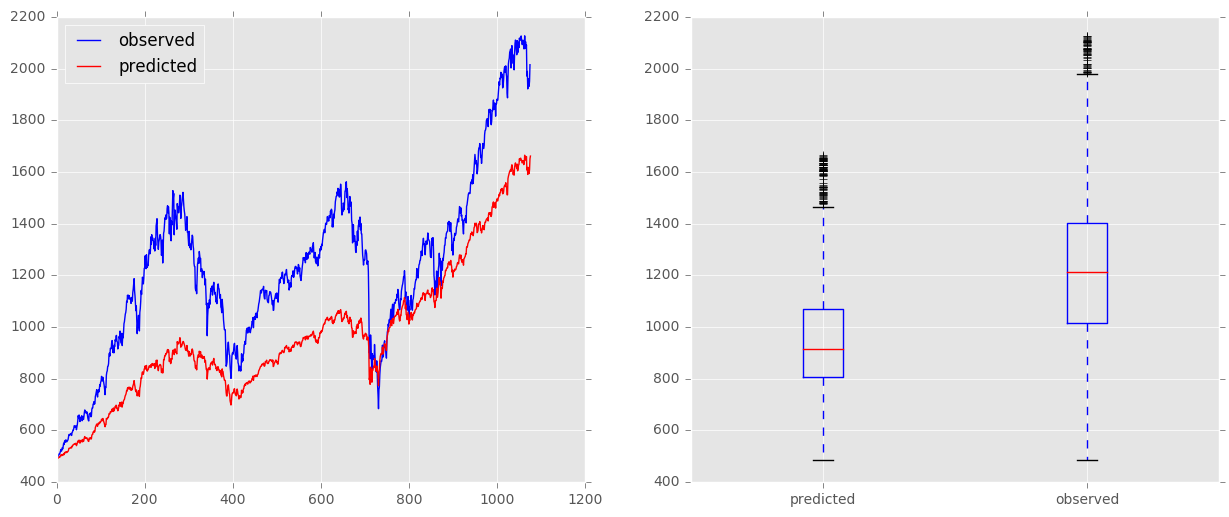

In [16]:
fig, axes = plt.subplots(1,2,figsize=(15,6))

axes[0].plot(y_train_original.values, label='observed', color='b')
axes[0].plot(preds_train, label='predicted', color='r')
axes[0].legend(loc='upper left')

axes[1].boxplot([preds_train, y_train_original.values], labels=['predicted', 'observed'])
#axes[1].set_xticklabels(['predicted', 'observed'])

plt.show()

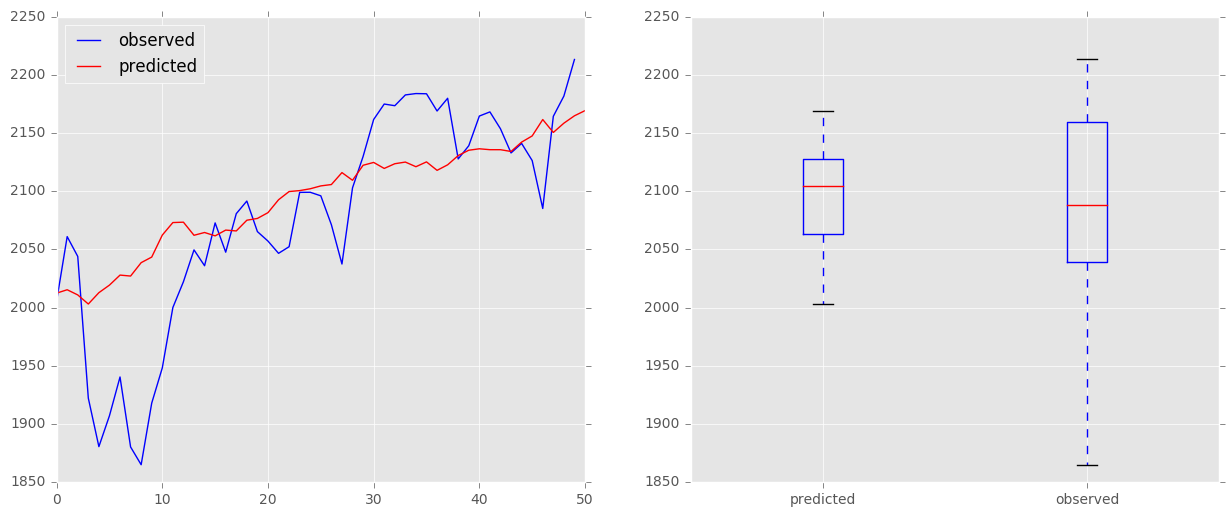

In [17]:
fig, axes = plt.subplots(1,2,figsize=(15,6))

axes[0].plot(y_test_original.values, label='observed', color='b')
axes[0].plot(preds_test, label='predicted', color='r')
axes[0].legend(loc='upper left')

axes[1].boxplot([preds_test, y_test_original.values])
axes[1].set_xticklabels(['predicted', 'observed'])

plt.show()

### Random Forest

#### Create model

In [18]:
tree = ensemble.RandomForestRegressor(
    n_estimators=80, 
    random_state=seed, 
    criterion="mse", 
    oob_score=True
).fit(X_train, y_train)

##### Generate predictions

In [19]:
preds_train = inverse_log_return(tree.predict(X_train), y_train_original)
preds_test = inverse_log_return(tree.predict(X_test), df['Adj Close'].ix[train_size+look_back:])

preds_train.shape, preds_test.shape

((1077,), (51,))

#### Evaluate model

In [20]:
# preds[1:] - it was inserted last value of train sample
train_mse = mean_squared_error(y_train_original.values, preds_train[1:])
test_mse = mean_squared_error(y_test_original.values, preds_test[1:])

print 'Model Score: {0:.2f} MSE ({1:.2f} RMSE)'.format(train_mse, np.sqrt(train_mse))
print 'Model Score: {0:.2f} MSE ({1:.2f} RMSE)'.format(test_mse, np.sqrt(test_mse))

Model Score: 33917.57 MSE (184.17 RMSE)
Model Score: 3543.64 MSE (59.53 RMSE)


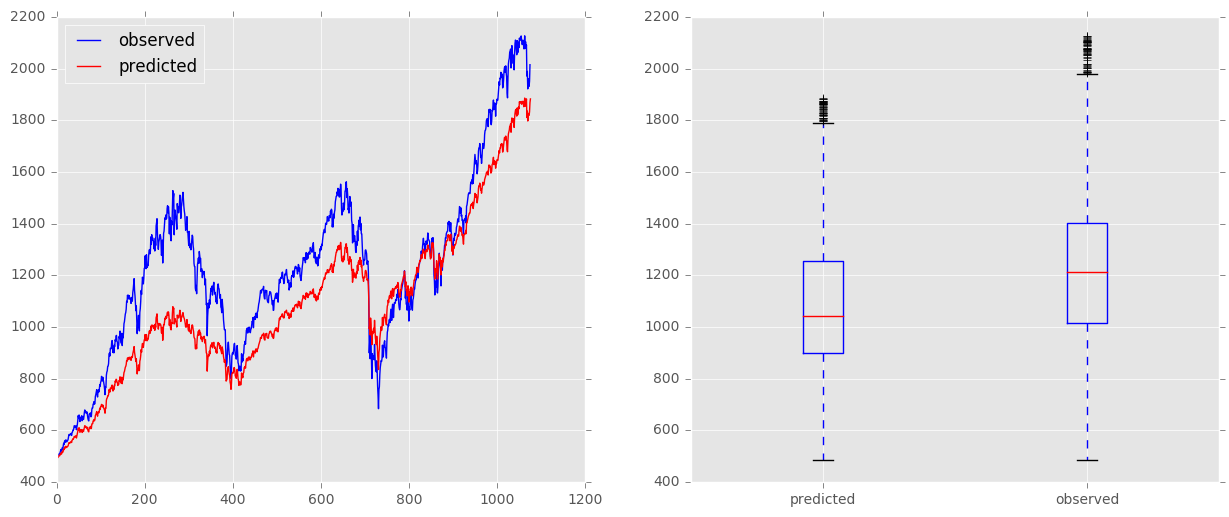

In [21]:
fig, axes = plt.subplots(1,2,figsize=(15,6))

axes[0].plot(y_train_original.values, label='observed', color='b')
axes[0].plot(preds_train, label='predicted', color='r')
axes[0].legend(loc='upper left')

axes[1].boxplot([preds_train, y_train_original.values], labels=['predicted', 'observed'])

plt.show()

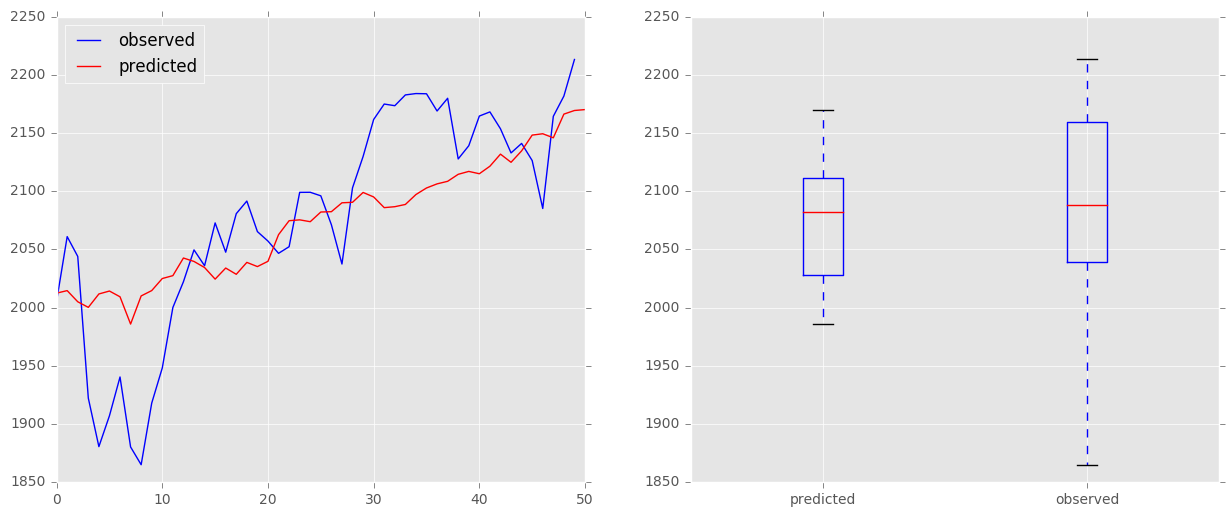

In [22]:
fig, axes = plt.subplots(1,2,figsize=(15,6))

axes[0].plot(y_test_original.values, label='observed', color='b')
axes[0].plot(preds_test, label='predicted', color='r')
axes[0].legend(loc='upper left')

axes[1].boxplot([preds_test, y_test_original.values])
axes[1].set_xticklabels(['predicted', 'observed'])

plt.show()

### Single KNN

#### Create model

In [23]:
# define optimal neighbors number using grid search
params = {'n_neighbors' :[4,6,8,16,26,52]}

grid = grid_search.GridSearchCV(
    neighbors.KNeighborsRegressor(weights='distance', metric='manhattan'), 
    params
).fit(X_train, y_train)

In [24]:
print 'Best model params: {}'.format(grid.best_params_)

Best model params: {'n_neighbors': 52}


#### Generate predictions

In [25]:
preds_train = inverse_log_return(grid.predict(X_train), y_train_original)
preds_test = inverse_log_return(grid.predict(X_test), df['Adj Close'].ix[train_size+look_back:])

preds_train.shape, preds_test.shape

((1077,), (51,))

#### Evaluate model

In [26]:
# preds[1:] - it was inserted last value of train sample
train_mse = mean_squared_error(y_train_original.values, preds_train[1:])
test_mse = mean_squared_error(y_test_original.values, preds_test[1:])

print 'Model Score: {0:.2f} MSE ({1:.2f} RMSE)'.format(train_mse, np.sqrt(train_mse))
print 'Model Score: {0:.2f} MSE ({1:.2f} RMSE)'.format(test_mse, np.sqrt(test_mse))

Model Score: 824.34 MSE (28.71 RMSE)
Model Score: 4306.36 MSE (65.62 RMSE)


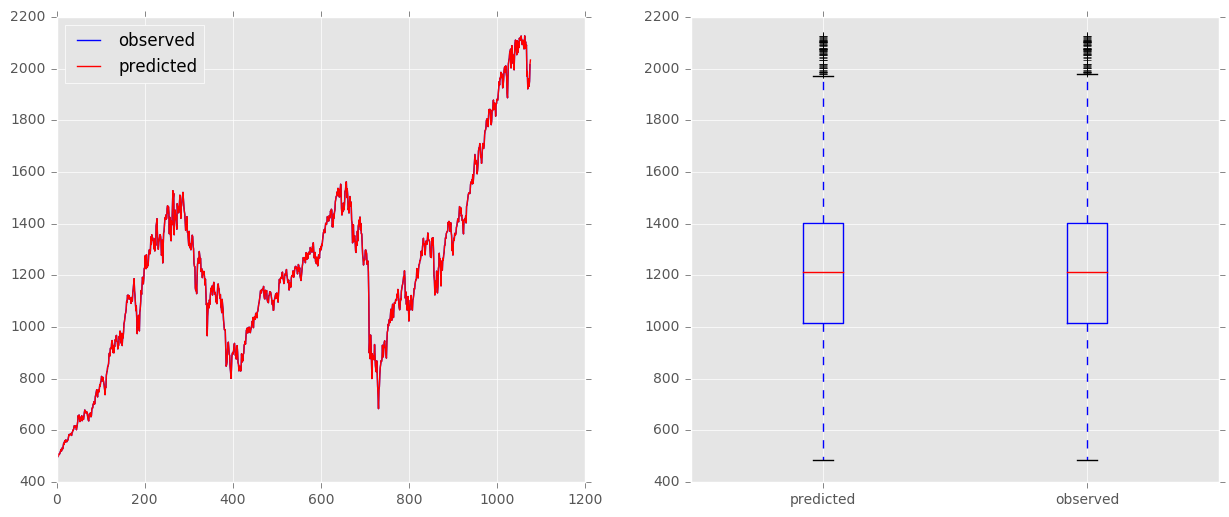

In [27]:
fig, axes = plt.subplots(1,2,figsize=(15,6))

axes[0].plot(y_train_original.values, label='observed', color='b')
axes[0].plot(preds_train, label='predicted', color='r')
axes[0].legend(loc='upper left')

axes[1].boxplot([preds_train, y_train_original.values], labels=['predicted', 'observed'])

plt.show()

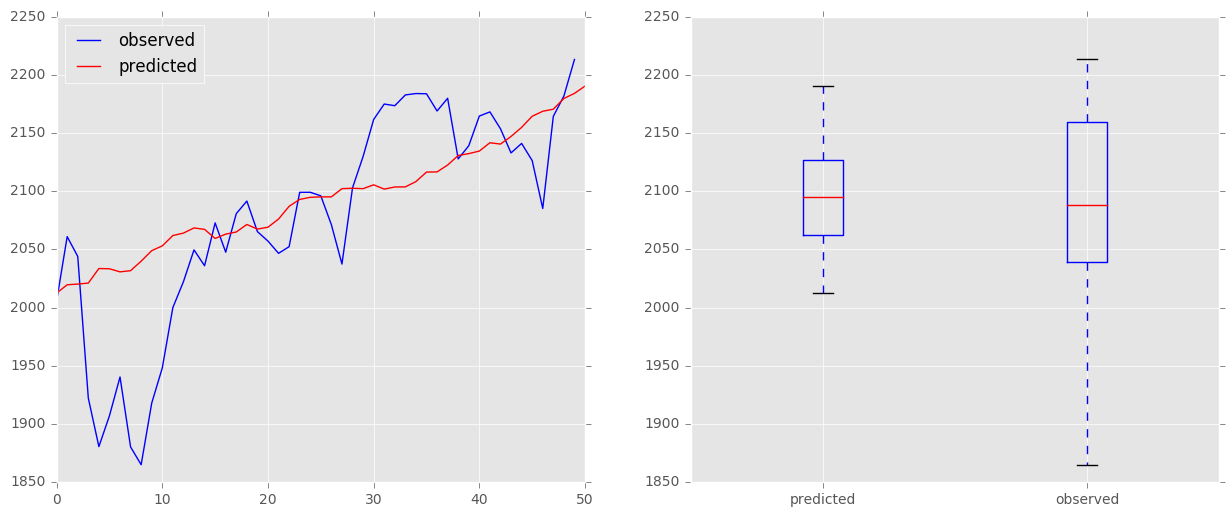

In [28]:
fig, axes = plt.subplots(1,2,figsize=(15,6))

axes[0].plot(y_test_original.values, label='observed', color='b')
axes[0].plot(preds_test, label='predicted', color='r')
axes[0].legend(loc='upper left')

axes[1].boxplot([preds_test, y_test_original.values])
axes[1].set_xticklabels(['predicted', 'observed'])

plt.show()

### Conclusion

All of considering models overfitted and generated bad predictions.This occur because the financial data is too noisy.In addition considering models generated prediction continuing the trend of recent observations, in other words this models ignore patterns contains in earlier observations.For stock market predictions need to use LSTM neural nets with backprop through time algorithm.